In [1]:
# import required library

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

import requests # download data
from pypinyin import lazy_pinyin # convert Chinese characters into pinyin
import tqdm # show the progress bar for the training

In [2]:
# download the name.txt file from github
url = 'https://raw.githubusercontent.com/wainshine/Chinese-Names-Corpus/master/Chinese_Names_Corpus/Chinese_Names_Corpus%EF%BC%88120W%EF%BC%89.txt'
data = requests.get(url).content
with open('Chinese_Names.txt', 'wb') as file:
    file.write(data)

In [3]:
# read the data
names = open('Chinese_Names.txt', 'r').read().splitlines()
names = names[3:] # clean the data 

print(f'There is {len(names)} names in total.')
print(f'The first ten names are {names[:10]}.')

There is 1144629 names in total.
The first ten names are ['阿安', '阿彬', '阿斌', '阿滨', '阿冰', '阿冰冰', '阿兵', '阿婵', '阿超', '阿朝'].


In [4]:
# convert name into pinyin
def name_to_pinyin(names):
    lastname_dict = {}
    firstname_dict = {}
    pinyin_names = []
    
    # obtain the pinyin of names
    for name in names:
        pinyin = lazy_pinyin(name) 
        pinyin_names.append(pinyin)
        
        # create a dictionary for pinyin and character
        def pinyin_dict(pinyin,name,name_dict):
            if pinyin not in name_dict.keys():
                name_dict.update({pinyin:[]})
            if name not in name_dict[pinyin]:
                name_dict[pinyin].append(name)
            return name_dict
        
        # a dict for last name
        lastname_dict = pinyin_dict(pinyin[0],name[0],lastname_dict)   
        
        # a dict for first name
        firstname_dict = pinyin_dict(pinyin[1],name[1],firstname_dict)   
        if len(name) == 3:
            firstname_dict = pinyin_dict(pinyin[2],name[2],firstname_dict) 
        
    return pinyin_names,firstname_dict,lastname_dict

pinyin_names,firstname_dict,lastname_dict = name_to_pinyin(names)
print(f'The pinyin of the first ten names: {pinyin_names[:10]}')

The pinyin of the first ten names: [['a', 'an'], ['a', 'bin'], ['a', 'bin'], ['a', 'bin'], ['a', 'bing'], ['a', 'bing', 'bing'], ['a', 'bing'], ['a', 'chan'], ['a', 'chao'], ['a', 'chao']]


In [5]:
# build the vocabulary with pinyin 
chars = list(set(''.join(names)))
pys = []

for char in chars:
    pinyin = lazy_pinyin(char)
    pys.extend(pinyin)

# map the vocabulary to/from integers 
pys = list(set(pys))
stoi = {s:i+1 for i,s in enumerate(pys)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(f'The size of the vocabulary is {len(stoi)}.')

The size of the vocabulary is 354.


In [6]:
# build the dataset
block_size = 3

def build_dataset(names):
    X, Y = [], []
    for w in names:
        context = [0] * block_size
        for ch in w + ['.']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(pinyin_names)
n1 = int(0.8*len(pinyin_names))
n2 = int(0.9*len(pinyin_names))

Xtr, Ytr = build_dataset(pinyin_names[:n1]) # train dataset
Xdev, Ydev = build_dataset(pinyin_names[n1:n2]) # validation dataset
Xte, Yte = build_dataset(pinyin_names[n2:]) # test dataset

In [7]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((354, 10), generator=g) # lookup table C

# set the weights and bias
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 354), generator=g)
b2 = torch.randn(354, generator=g)

parameters = [C, W1, b1, W2, b2]

print(f'The number of parameters in total: {sum(p.nelement() for p in parameters)}.')

The number of parameters in total: 80894.


In [8]:
for p in parameters:
    p.requires_grad = True

# record the loss by steps
lossi = []
stepi = []

In [9]:
# train the model

for i in tqdm.tqdm(range(200000)):
    
    # construct the minibatch 
    ix = torch.randint(0, Xtr.shape[0], (64,)) 

    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

100%|██████████████████████████████████| 200000/200000 [32:56<00:00, 101.17it/s]


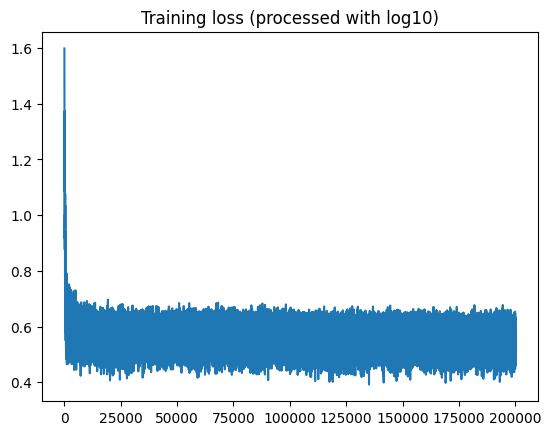

In [10]:
# plot the training loss
plt.title('Training loss (processed with log10)')
plt.plot(stepi, lossi)

In [11]:
# validation loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.6530, grad_fn=<NllLossBackward0>)

In [12]:
# test loss
emb = C[Xte] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte)
loss

tensor(3.6531, grad_fn=<NllLossBackward0>)

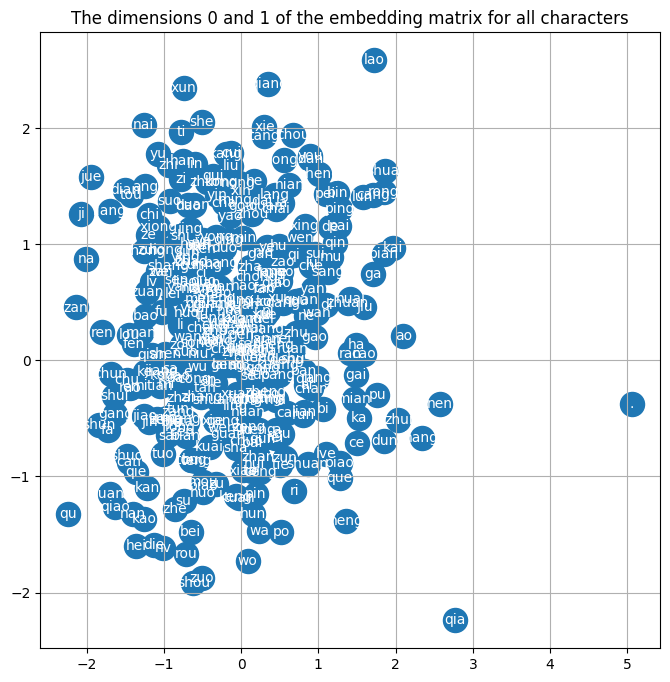

In [13]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=300)
plt.title('The dimensions 0 and 1 of the embedding matrix for all characters')
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2141433 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize the context
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    name_pinyin = []
    for i in out:
        name_pinyin.append(itos[i])
        
        lastname = random.choice(lastname_dict[name_pinyin[0]])
        first_name = []
        
        for pinyin in name_pinyin[1:-1]:
            first_name.append(random.choice(firstname_dict[pinyin]))
        firstname = ''.join(first_name)
    print(lastname + firstname)

河锡果
孙睿轩
皇椿梁
程临
谌琏胜
谢麟改
普亲
叶生豪
郑仕修
承致丰
飞约轶
尧学贞
徐听基
皇傅封
陈赫州
蔡慧洁
赵邢渭
庚镝蓝
名休苓
张效辰
